In [199]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet101
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, Flatten, Input, Concatenate
import pickle
from sklearn.preprocessing import OneHotEncoder
from keras import Sequential
from keras.applications.xception import Xception
from keras.layers import BatchNormalization, Activation, Dropout, MaxPooling2D,Conv2D
from tensorflow.keras.layers.experimental import RandomFourierFeatures
import time
import os
from tensorflow_addons.metrics import F1Score

Import Training and test data

In [200]:
size = 48
num_classes = 6
NUM_EPOCHS = 10

In [201]:
from keras import backend as K

def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

auc_metric = tf.keras.metrics.AUC(
num_thresholds=200, curve="ROC",
summation_method="interpolation",
thresholds=None, multi_label=False
)
f1_score = F1Score(num_classes=6)

In [202]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.001)

Change_input_layer, change the input layer to have only 1 channel (black and white). It sets the average of the pre-trained weights for the first layer and for the rest of the layers it uses the same weights.

In [203]:
def change_input_layer(pretrained_model, first_conv, h, w, c):
    pretrained_config = pretrained_model.get_config()

    # Change the input shape from the model
    pretrained_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

    updated_model = Model.from_config(pretrained_config)


    def avg_weights(weights):
        average_weights = np.mean(weights, axis=-2).reshape(weights[:, :, -1:, :].shape)
        return(average_weights)

    pretrained_updated_config = updated_model.get_config()
    pretrained_updated_layer_names = [pretrained_updated_config['layers'][x]['name'] for x in range(len(pretrained_updated_config['layers']))]
    print(pretrained_updated_layer_names)
    first_conv_name = pretrained_updated_layer_names[first_conv]

    for layer in pretrained_model.layers:
        if layer.name in pretrained_updated_layer_names:
            if layer.get_weights() != []:  #All convolutional layers and layers with weights (no input layer or any pool layers)
                target_layer = updated_model.get_layer(layer.name)
            
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
                    
                    weights_single_channel = avg_weights(weights)
                                                                
                    target_layer.set_weights([weights_single_channel, biases])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
            
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want.
    updated_model.summary()
    return updated_model


Simple CNN

In [204]:
# Suggested by tensorflow
simplecnn = Sequential()
simplecnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
simplecnn.add(MaxPooling2D((2, 2)))
simplecnn.add(Conv2D(64, (3, 3), activation='relu'))
simplecnn.add(MaxPooling2D((2, 2)))
simplecnn.add(Conv2D(64, (3, 3), activation='relu'))
simplecnn.add(Flatten())
simplecnn.add(Dense(units=1024, kernel_regularizer=regularizer))
simplecnn.add(BatchNormalization(scale=False,
                                   center=False))
simplecnn.add(Activation('relu'))
simplecnn.add(Dropout(rate=0.4))
simplecnn.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 


VGG16

In [205]:
vgg16_model = VGG16(include_top=False, weights='imagenet')
vgg16_updated = change_input_layer(vgg16_model, 1, size, size, 1)

['input_10', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       

In [206]:
final_vgg16 = Sequential()
final_vgg16.add(vgg16_updated)
final_vgg16.add(Flatten())
final_vgg16.add(Dense(units=1024, kernel_regularizer=regularizer))
final_vgg16.add(BatchNormalization(scale=False,
                                   center=False))
final_vgg16.add(Activation('relu'))
final_vgg16.add(Dropout(rate=0.4))
final_vgg16.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 


VGG19

https://github.com/bnsreenu/python_for_microscopists

In [208]:
pretrained_model = VGG19(include_top=False, weights='imagenet')


In [209]:
vgg19_model = VGG19(include_top=False, weights='imagenet')
vgg19_updated = change_input_layer(vgg19_model, 1, size, size, 1)

['input_12', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                               

In [210]:
final_vgg19 = Sequential()
final_vgg19.add(vgg19_updated)
final_vgg19.add(Flatten())
final_vgg19.add(Dense(units=1024, kernel_regularizer=regularizer))
final_vgg19.add(BatchNormalization(scale=False,
                                   center=False))
final_vgg19.add(Activation('relu'))
final_vgg19.add(Dropout(rate=0.4))
final_vgg19.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

Resnet

In [211]:
resnet_model = ResNet101(include_top=False, weights='imagenet')
resnet_model.summary()
resnet_updated = change_input_layer(resnet_model, 2, size, size, 1)
resnet_updated.trainable = True

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_13[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                       

In [212]:
resnet_updated.trainable = False
final_resnet = Sequential()
final_resnet.add(resnet_updated)
final_resnet.add(Flatten())
final_resnet.add(Dense(units=1024, kernel_regularizer=regularizer))
final_resnet.add(BatchNormalization(scale=False,
                                   center=False))
final_resnet.add(Activation('relu'))
final_resnet.add(Dropout(rate=0.4))
final_resnet.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

DenseNet

In [213]:
def change_input_layer_dense(pretrained_model, first_conv, h, w, c):
    pretrained_config = pretrained_model.get_config()

    # Change the input shape from the model
    pretrained_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

    updated_model = Model.from_config(pretrained_config)


    def avg_weights(weights):
        average_weights = np.mean(weights, axis=-2).reshape(weights[:, :, -1:, :].shape)
        return(average_weights)

    pretrained_updated_config = updated_model.get_config()
    pretrained_updated_layer_names = [pretrained_updated_config['layers'][x]['name'] for x in range(len(pretrained_updated_config['layers']))]
    print(pretrained_updated_layer_names)
    first_conv_name = pretrained_updated_layer_names[first_conv]

    for layer in pretrained_model.layers:
        if layer.name in pretrained_updated_layer_names:
            if layer.get_weights() != []:  #All convolutional layers and layers with weights (no input layer or any pool layers)
                target_layer = updated_model.get_layer(layer.name)
            
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    
                    weights_single_channel = avg_weights(weights)
                                                                
                    target_layer.set_weights([weights_single_channel])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
            
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want.
    updated_model.summary()
    return updated_model

In [214]:
densenet_model = DenseNet121(include_top=False, weights='imagenet')
densenet_updated = change_input_layer_dense(densenet_model, 2, size, size, 1)

['input_14', 'zero_padding2d_2', 'conv1/conv', 'conv1/bn', 'conv1/relu', 'zero_padding2d_3', 'pool1', 'conv2_block1_0_bn', 'conv2_block1_0_relu', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_concat', 'conv2_block2_0_bn', 'conv2_block2_0_relu', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_concat', 'conv2_block3_0_bn', 'conv2_block3_0_relu', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_concat', 'conv2_block4_0_bn', 'conv2_block4_0_relu', 'conv2_block4_1_conv', 'conv2_block4_1_bn', 'conv2_block4_1_relu', 'conv2_block4_2_conv', 'conv2_block4_concat', 'conv2_block5_0_bn', 'conv2_block5_0_relu', 'conv2_block5_1_conv', 'conv2_block5_1_bn', 'conv2_block5_1_relu', 'conv2_block5_2_conv', 'conv2_block5_concat', 'conv2_block6_0_bn', 'conv2_block6_0_relu', 'conv2_block6_1_conv', 'conv2_block6_1_bn', 'conv2_block6_1_relu', 'c

In [215]:
final_densenet = Sequential()
final_densenet.add(densenet_updated)
final_densenet.add(Flatten())
final_densenet.add(Dense(units=1024, kernel_regularizer=regularizer))
final_densenet.add(BatchNormalization(scale=False,
                                   center=False))
final_densenet.add(Activation('relu'))
final_densenet.add(Dropout(rate=0.4))
final_densenet.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

Xception

In [216]:
xception_model = Xception(include_top=False, weights='imagenet')
xception_model.summary()
xception_updated = change_input_layer_dense(xception_model, 1, size, size, 1)

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_15[0][0]']               
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

In [217]:
final_xception = Sequential()
final_xception.add(xception_updated)
final_xception.add(Flatten())
final_xception.add(Dense(units=1024, kernel_regularizer=regularizer))
final_xception.add(BatchNormalization(scale=False,
                                   center=False))
final_xception.add(Activation('relu'))
final_xception.add(Dropout(rate=0.4))
final_xception.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

Training Emotion

In [218]:
import pandas as pd
import numpy as np

CK+

In [22]:
CK_Emotion_X_train = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_X_train")
CK_Emotion_y_train = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_y_train")
CK_Emotion_X_val = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_X_val")
CK_Emotion_y_val = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_y_val")

In [23]:
CK_Emotion_X_test = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_X_test")
CK_Emotion_y_test = pd.read_pickle("./Clean_datasets/CK+/CK+_Emotion_y_test")

In [24]:
dataset_name = "CK_Emotion"

In [14]:
CK_FACS_X_train = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_X_train")
CK_FACS_y_train = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_y_train")
CK_FACS_X_val = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_X_val")
CK_FACS_y_val = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_y_val")

In [15]:
X_train = CK_FACS_X_train
X_val = CK_FACS_X_val
y_train = CK_FACS_y_train
y_val = CK_FACS_y_val



In [28]:
y_train = CK_FACS_y_train
y_val = CK_FACS_y_val

In [25]:
X_train = CK_Emotion_X_train
X_val = CK_Emotion_X_val
X_test = CK_Emotion_X_test
y_train = CK_Emotion_y_train
y_val = CK_Emotion_y_val
y_test = CK_Emotion_y_test

EmotioNet

In [153]:
EmotioNet_Emotion_X_train = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_Emotion_X_train")
EmotioNet_Emotion_y_train = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_Emotion_y_train")
EmotioNet_Emotion_X_val = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_Emotion_X_val")
EmotioNet_Emotion_y_val = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_Emotion_y_val")

In [154]:
X_train = EmotioNet_Emotion_X_train
X_val = EmotioNet_Emotion_X_val
y_train = EmotioNet_Emotion_y_train
y_val = EmotioNet_Emotion_y_val

In [155]:
dataset_name = "EmotioNet_Emotion"

MMI

In [68]:
MMI_Emotion_X_train = pd.read_pickle("./Clean_datasets/MMI/MMI_Emotion_X_train")
MMI_Emotion_y_train = pd.read_pickle("./Clean_datasets/MMI/MMI_Emotion_y_train")
MMI_Emotion_X_val = pd.read_pickle("./Clean_datasets/MMI/MMI_Emotion_X_val")
MMI_Emotion_y_val = pd.read_pickle("./Clean_datasets/MMI/MMI_Emotion_y_val")

In [110]:
X_train = MMI_Emotion_X_train
X_val = MMI_Emotion_X_val
y_train = MMI_Emotion_y_train
y_val = MMI_Emotion_y_val

In [70]:
dataset_name = "MMI_Emotion"

FER2013

In [219]:
FER2013_Emotion_X_train = pd.read_pickle("./Clean_datasets/FER2013/FER2013_Emotion_X_train")
FER2013_Emotion_y_train = pd.read_pickle("./Clean_datasets/FER2013/FER2013_Emotion_Y_train")
FER2013_Emotion_X_val = pd.read_pickle("./Clean_datasets/FER2013/FER2013_Emotion_X_val")
FER2013_Emotion_y_val = pd.read_pickle("./Clean_datasets/FER2013/FER2013_Emotion_Y_val")

In [220]:
X_train = FER2013_Emotion_X_train
X_val = FER2013_Emotion_X_val
y_train = FER2013_Emotion_y_train
y_val = FER2013_Emotion_y_val

In [221]:
dataset_name = "FER2013_Emotion"

Data pre-processing to fit the models

In [74]:
from PIL import Image

In [80]:
X_train[0].shape

(224, 224, 1)

In [222]:
from skimage.transform import resize
def resize_images(images):
    resized_images = []
    for image in images:
        resized_images.append(resize(image, (size, size)))
    return np.asarray(resized_images).astype('float32')

In [223]:
X_train = resize_images(X_train)
X_val = resize_images(X_val)
#X_test = resize_images(X_val)

In [224]:
X_train = np.resize(X_train,(len(X_train),size,size))
X_val = np.resize(X_val,(len(X_val),size,size))

In [225]:
import numpy as np
from skimage.feature import hog

def extract_hog_features(images):
    features = []
    for image in images:
        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        features.append(fd)
    return np.array(features)

In [160]:
import cv2
cv2.imshow("test",X_train[1])
cv2.waitKey(0)
cv2.destroyAllWindows

<function destroyAllWindows>

In [226]:
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)


In [227]:
X_train = np.resize(X_train,(len(X_train),size,size,1))
X_val = np.resize(X_val,(len(X_val),size,size,1))
X_test = np.resize(X_test,(len(X_test),size,size,1))

In [228]:
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(X_test))

(23744, 48, 48, 1)
(2973, 48, 48, 1)
(31, 48, 48, 1)


In [229]:
y_train

1        6
2        6
3        2
4        5
5        1
        ..
28704    2
28705    5
28706    6
28707    5
28708    6
Name: Emotion, Length: 23744, dtype: object

In [230]:
from sklearn.preprocessing import OneHotEncoder

In [231]:
y_train = np.array(np.array(y_train).reshape(-1, 1))
y_val = np.array(np.array(y_val).reshape(-1, 1))
y_test = np.array(np.array(y_test).reshape(-1, 1))

In [232]:
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder.fit_transform(y_train)
onehot_encoder2 = OneHotEncoder(sparse_output=False)
y_val = onehot_encoder2.fit_transform(y_val)
y_test = onehot_encoder2.fit_transform(y_test)

In [233]:
np.shape(y_val)

(2973, 6)

In [234]:
np.shape(y_train)

(23744, 6)

In [235]:
np.shape(y_test)

(744, 2)

In [241]:
NUM_EPOCHS = 10

Metrics

In [237]:
precision = keras.metrics.Precision(name="Precision")
recall = keras.metrics.Recall(name="Recall")


SVM

In [238]:
import datetime
folder_name = 'logs/SVM'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [239]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/SVM'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [240]:
SVM = keras.Sequential(
    [
        keras.Input(shape=(X_train_hog.shape[1],)),
        RandomFourierFeatures(
            output_dim=4096, scale=10.0, kernel_initializer="gaussian"
        ),
        Dense(units=num_classes),
    ]
)
SVM.compile(
    optimizer='adam',
    loss=keras.losses.hinge,
    metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])


history_SVM = SVM.fit(X_train_hog,y_train,validation_data=(X_val_hog,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/20
742/742 [==============================] - ETA: 0s - loss: 0.3845 - Precision: 0.7534 - Recall: 0.1049 - custom_f1: 0.1719 - auc_1: 0.5739 - accuracy: 0.4015

INFO:tensorflow:Assets written to: ./chkpts\SVMFER2013_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\SVMFER2013_Emotion\assets


742/742 [==============================] - 45s 60ms/step - loss: 0.3845 - Precision: 0.7534 - Recall: 0.1049 - custom_f1: 0.1719 - auc_1: 0.5739 - accuracy: 0.4015 - val_loss: 0.3596 - val_Precision: 0.7227 - val_Recall: 0.2270 - val_custom_f1: 0.3411 - val_auc_1: 0.6278 - val_accuracy: 0.4181
Epoch 2/20
742/742 [==============================] - 44s 59ms/step - loss: 0.3719 - Precision: 0.7661 - Recall: 0.1528 - custom_f1: 0.2457 - auc_1: 0.5995 - accuracy: 0.4404 - val_loss: 0.3456 - val_Precision: 0.8115 - val_Recall: 0.1709 - val_custom_f1: 0.2772 - val_auc_1: 0.6107 - val_accuracy: 0.4548
Epoch 3/20
742/742 [==============================] - 43s 58ms/step - loss: 0.3708 - Precision: 0.7697 - Recall: 0.1614 - custom_f1: 0.2590 - auc_1: 0.6044 - accuracy: 0.4467 - val_loss: 0.3825 - val_Precision: 0.7209 - val_Recall: 0.1877 - val_custom_f1: 0.2940 - val_auc_1: 0.6051 - val_accuracy: 0.4168
Epoch 4/20
742/742 [==============================] - 43s 58ms/step - loss: 0.3680 - Precisio

INFO:tensorflow:Assets written to: ./chkpts\SVMFER2013_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\SVMFER2013_Emotion\assets


742/742 [==============================] - 48s 65ms/step - loss: 0.3636 - Precision: 0.7695 - Recall: 0.1720 - custom_f1: 0.2727 - auc_1: 0.6128 - accuracy: 0.4682 - val_loss: 0.3703 - val_Precision: 0.6903 - val_Recall: 0.2355 - val_custom_f1: 0.3469 - val_auc_1: 0.6369 - val_accuracy: 0.4578
Epoch 11/20
742/742 [==============================] - 42s 56ms/step - loss: 0.3600 - Precision: 0.7875 - Recall: 0.1722 - custom_f1: 0.2754 - auc_1: 0.6134 - accuracy: 0.4698 - val_loss: 0.3466 - val_Precision: 0.8656 - val_Recall: 0.1473 - val_custom_f1: 0.2464 - val_auc_1: 0.6005 - val_accuracy: 0.4689
Epoch 12/20
742/742 [==============================] - 41s 55ms/step - loss: 0.3558 - Precision: 0.7860 - Recall: 0.1703 - custom_f1: 0.2720 - auc_1: 0.6110 - accuracy: 0.4736 - val_loss: 0.3623 - val_Precision: 0.8403 - val_Recall: 0.1345 - val_custom_f1: 0.2261 - val_auc_1: 0.6071 - val_accuracy: 0.4595
Epoch 13/20
742/742 [==============================] - 52s 70ms/step - loss: 0.3602 - Preci

Simple CNN

In [242]:
import datetime
folder_name = 'logs/SimpleCNN'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [243]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/SimpleCNN'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [244]:
simplecnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [245]:
history_simplecnn = simplecnn.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/10
742/742 [==============================] - ETA: 0s - loss: 1.7994 - Precision: 0.6987 - Recall: 0.2295 - custom_f1: 0.3457 - auc_1: 0.7684 - accuracy: 0.4631

INFO:tensorflow:Assets written to: ./chkpts\SimpleCNNFER2013_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\SimpleCNNFER2013_Emotion\assets


742/742 [==============================] - 410s 551ms/step - loss: 1.7994 - Precision: 0.6987 - Recall: 0.2295 - custom_f1: 0.3457 - auc_1: 0.7684 - accuracy: 0.4631 - val_loss: 2.1269 - val_Precision: 0.2279 - val_Recall: 0.2015 - val_custom_f1: 0.2135 - val_auc_1: 0.7254 - val_accuracy: 0.2297
Epoch 2/10
742/742 [==============================] - ETA: 0s - loss: 1.4198 - Precision: 0.7158 - Recall: 0.3131 - custom_f1: 0.4322 - auc_1: 0.8489 - accuracy: 0.5187

INFO:tensorflow:Assets written to: ./chkpts\SimpleCNNFER2013_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\SimpleCNNFER2013_Emotion\assets


742/742 [==============================] - 399s 538ms/step - loss: 1.4198 - Precision: 0.7158 - Recall: 0.3131 - custom_f1: 0.4322 - auc_1: 0.8489 - accuracy: 0.5187 - val_loss: 1.5349 - val_Precision: 0.6201 - val_Recall: 0.3091 - val_custom_f1: 0.4100 - val_auc_1: 0.8224 - val_accuracy: 0.4706
Epoch 3/10
742/742 [==============================] - ETA: 0s - loss: 1.3701 - Precision: 0.7204 - Recall: 0.3380 - custom_f1: 0.4568 - auc_1: 0.8609 - accuracy: 0.5385

INFO:tensorflow:Assets written to: ./chkpts\SimpleCNNFER2013_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\SimpleCNNFER2013_Emotion\assets


742/742 [==============================] - 398s 537ms/step - loss: 1.3701 - Precision: 0.7204 - Recall: 0.3380 - custom_f1: 0.4568 - auc_1: 0.8609 - accuracy: 0.5385 - val_loss: 1.4985 - val_Precision: 0.6041 - val_Recall: 0.4265 - val_custom_f1: 0.4983 - val_auc_1: 0.8453 - val_accuracy: 0.5156
Epoch 4/10
742/742 [==============================] - 397s 534ms/step - loss: 1.3412 - Precision: 0.7314 - Recall: 0.3718 - custom_f1: 0.4898 - auc_1: 0.8710 - accuracy: 0.5563 - val_loss: 1.4634 - val_Precision: 0.5979 - val_Recall: 0.3185 - val_custom_f1: 0.4128 - val_auc_1: 0.8399 - val_accuracy: 0.4773
Epoch 5/10
742/742 [==============================] - 396s 533ms/step - loss: 1.3486 - Precision: 0.7251 - Recall: 0.3830 - custom_f1: 0.4981 - auc_1: 0.8761 - accuracy: 0.5672 - val_loss: 1.5626 - val_Precision: 0.5898 - val_Recall: 0.4033 - val_custom_f1: 0.4777 - val_auc_1: 0.8382 - val_accuracy: 0.4874
Epoch 6/10
742/742 [==============================] - ETA: 0s - loss: 1.3069 - Precisio

INFO:tensorflow:Assets written to: ./chkpts\SimpleCNNFER2013_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\SimpleCNNFER2013_Emotion\assets


742/742 [==============================] - 398s 537ms/step - loss: 1.3069 - Precision: 0.7381 - Recall: 0.4100 - custom_f1: 0.5247 - auc_1: 0.8832 - accuracy: 0.5819 - val_loss: 1.5482 - val_Precision: 0.5932 - val_Recall: 0.4346 - val_custom_f1: 0.4999 - val_auc_1: 0.8450 - val_accuracy: 0.5035
Epoch 7/10
742/742 [==============================] - 394s 530ms/step - loss: 1.2917 - Precision: 0.7364 - Recall: 0.4164 - custom_f1: 0.5293 - auc_1: 0.8869 - accuracy: 0.5852 - val_loss: 1.3977 - val_Precision: 0.6907 - val_Recall: 0.3680 - val_custom_f1: 0.4771 - val_auc_1: 0.8617 - val_accuracy: 0.5395
Epoch 8/10
742/742 [==============================] - 392s 529ms/step - loss: 1.2965 - Precision: 0.7413 - Recall: 0.4356 - custom_f1: 0.5463 - auc_1: 0.8920 - accuracy: 0.5942 - val_loss: 1.6441 - val_Precision: 0.5881 - val_Recall: 0.4164 - val_custom_f1: 0.4853 - val_auc_1: 0.8387 - val_accuracy: 0.4982
Epoch 9/10
742/742 [==============================] - 393s 529ms/step - loss: 1.2665 - 

VGG16

In [246]:
import datetime
folder_name = 'logs/VGG16'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [247]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/VGG16'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [248]:
final_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [249]:
history_vgg16 = final_vgg16.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/10
706/742 [===========================>..] - ETA: 1:35 - loss: 1.9779 - Precision: 0.4493 - Recall: 0.2164 - custom_f1: 0.2751 - auc_1: 0.7371 - accuracy: 0.3646

KeyboardInterrupt: 

VGG19

In [183]:
folder_name = 'logs/VGG19'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [184]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/VGG19'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [185]:
final_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [186]:
history_vgg19 = final_vgg19.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 2.0217 - Precision: 0.6860 - Recall: 0.6109 - custom_f1: 0.6374 - auc: 0.8654 - accuracy: 0.6351

INFO:tensorflow:Assets written to: ./chkpts\VGG19EmotioNet_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\VGG19EmotioNet_Emotion\assets


28/28 [==============================] - 184s 7s/step - loss: 2.0217 - Precision: 0.6860 - Recall: 0.6109 - custom_f1: 0.6374 - auc: 0.8654 - accuracy: 0.6351 - val_loss: 2.3969 - val_Precision: 0.7248 - val_Recall: 0.7182 - val_custom_f1: 0.7103 - val_auc: 0.8920 - val_accuracy: 0.7182
Epoch 2/20
28/28 [==============================] - 178s 6s/step - loss: 1.2475 - Precision: 0.8278 - Recall: 0.7400 - custom_f1: 0.7802 - auc: 0.9517 - accuracy: 0.7834 - val_loss: 3.0119 - val_Precision: 0.7000 - val_Recall: 0.7000 - val_custom_f1: 0.6920 - val_auc: 0.8516 - val_accuracy: 0.7000
Epoch 3/20
28/28 [==============================] - 176s 6s/step - loss: 1.0144 - Precision: 0.8759 - Recall: 0.7970 - custom_f1: 0.8334 - auc: 0.9749 - accuracy: 0.8415 - val_loss: 2.7497 - val_Precision: 0.7064 - val_Recall: 0.7000 - val_custom_f1: 0.6979 - val_auc: 0.8575 - val_accuracy: 0.7000
Epoch 4/20
28/28 [==============================] - 179s 6s/step - loss: 0.8808 - Precision: 0.9072 - Recall: 0.84

INFO:tensorflow:Assets written to: ./chkpts\VGG19EmotioNet_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\VGG19EmotioNet_Emotion\assets


28/28 [==============================] - 214s 8s/step - loss: 0.7457 - Precision: 0.9273 - Recall: 0.8871 - custom_f1: 0.9027 - auc: 0.9890 - accuracy: 0.9099 - val_loss: 1.6554 - val_Precision: 0.7429 - val_Recall: 0.7091 - val_custom_f1: 0.7138 - val_auc: 0.9019 - val_accuracy: 0.7273
Epoch 7/20
28/28 [==============================] - 173s 6s/step - loss: 0.7101 - Precision: 0.9379 - Recall: 0.8951 - custom_f1: 0.9133 - auc: 0.9925 - accuracy: 0.9145 - val_loss: 2.1586 - val_Precision: 0.7103 - val_Recall: 0.6909 - val_custom_f1: 0.6956 - val_auc: 0.8927 - val_accuracy: 0.7000
Epoch 8/20
28/28 [==============================] - 154s 6s/step - loss: 0.7060 - Precision: 0.9394 - Recall: 0.9019 - custom_f1: 0.9201 - auc: 0.9895 - accuracy: 0.9202 - val_loss: 2.4564 - val_Precision: 0.7037 - val_Recall: 0.6909 - val_custom_f1: 0.6927 - val_auc: 0.8661 - val_accuracy: 0.6909
Epoch 9/20
28/28 [==============================] - 154s 6s/step - loss: 0.6779 - Precision: 0.9431 - Recall: 0.90

ResNet

In [187]:
folder_name = 'logs/ResNet'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [188]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/ResNet'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [189]:
final_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [190]:
history_resnet = final_resnet.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 1.6295 - Precision: 0.6730 - Recall: 0.5775 - custom_f1: 0.6089 - auc: 0.8539 - accuracy: 0.6169

INFO:tensorflow:Assets written to: ./chkpts\ResNetEmotioNet_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\ResNetEmotioNet_Emotion\assets


28/28 [==============================] - 191s 7s/step - loss: 1.6295 - Precision: 0.6730 - Recall: 0.5775 - custom_f1: 0.6089 - auc: 0.8539 - accuracy: 0.6169 - val_loss: 13.4225 - val_Precision: 0.6818 - val_Recall: 0.6818 - val_custom_f1: 0.6763 - val_auc: 0.8091 - val_accuracy: 0.6818
Epoch 2/20
28/28 [==============================] - 190s 7s/step - loss: 0.9893 - Precision: 0.7968 - Recall: 0.6887 - custom_f1: 0.7413 - auc: 0.9245 - accuracy: 0.7400 - val_loss: 15.2962 - val_Precision: 0.6818 - val_Recall: 0.6818 - val_custom_f1: 0.6763 - val_auc: 0.8091 - val_accuracy: 0.6818
Epoch 3/20
28/28 [==============================] - 190s 7s/step - loss: 0.8576 - Precision: 0.8122 - Recall: 0.7001 - custom_f1: 0.7508 - auc: 0.9424 - accuracy: 0.7605 - val_loss: 25.6426 - val_Precision: 0.6818 - val_Recall: 0.6818 - val_custom_f1: 0.6763 - val_auc: 0.8091 - val_accuracy: 0.6818
Epoch 4/20
28/28 [==============================] - 190s 7s/step - loss: 0.7854 - Precision: 0.8261 - Recall: 0

DenseNet

In [191]:
folder_name = 'logs/DenseNet'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [192]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/DenseNet'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [193]:
final_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [194]:
history_densenet = final_densenet.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 2.0332 - Precision: 0.6721 - Recall: 0.6292 - custom_f1: 0.6492 - auc: 0.8699 - accuracy: 0.6477

INFO:tensorflow:Assets written to: ./chkpts\DenseNetEmotioNet_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\DenseNetEmotioNet_Emotion\assets


28/28 [==============================] - 110s 4s/step - loss: 2.0332 - Precision: 0.6721 - Recall: 0.6292 - custom_f1: 0.6492 - auc: 0.8699 - accuracy: 0.6477 - val_loss: 2.2069 - val_Precision: 0.7570 - val_Recall: 0.7364 - val_custom_f1: 0.7620 - val_auc: 0.9067 - val_accuracy: 0.7364
Epoch 2/20
28/28 [==============================] - 78s 3s/step - loss: 1.0468 - Precision: 0.8756 - Recall: 0.8267 - custom_f1: 0.8508 - auc: 0.9744 - accuracy: 0.8461 - val_loss: 2.0273 - val_Precision: 0.7593 - val_Recall: 0.7455 - val_custom_f1: 0.7469 - val_auc: 0.9044 - val_accuracy: 0.7545
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 0.8417 - Precision: 0.9275 - Recall: 0.8757 - custom_f1: 0.8995 - auc: 0.9904 - accuracy: 0.9031

INFO:tensorflow:Assets written to: ./chkpts\DenseNetEmotioNet_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\DenseNetEmotioNet_Emotion\assets


28/28 [==============================] - 120s 4s/step - loss: 0.8417 - Precision: 0.9275 - Recall: 0.8757 - custom_f1: 0.8995 - auc: 0.9904 - accuracy: 0.9031 - val_loss: 1.4848 - val_Precision: 0.7778 - val_Recall: 0.7636 - val_custom_f1: 0.7725 - val_auc: 0.9363 - val_accuracy: 0.7636
Epoch 4/20
28/28 [==============================] - 73s 3s/step - loss: 0.6761 - Precision: 0.9682 - Recall: 0.9361 - custom_f1: 0.9519 - auc: 0.9968 - accuracy: 0.9521 - val_loss: 1.4526 - val_Precision: 0.7788 - val_Recall: 0.7364 - val_custom_f1: 0.7607 - val_auc: 0.9326 - val_accuracy: 0.7545
Epoch 5/20
28/28 [==============================] - 75s 3s/step - loss: 0.6114 - Precision: 0.9676 - Recall: 0.9532 - custom_f1: 0.9611 - auc: 0.9958 - accuracy: 0.9624 - val_loss: 1.4120 - val_Precision: 0.7925 - val_Recall: 0.7636 - val_custom_f1: 0.7688 - val_auc: 0.9331 - val_accuracy: 0.7636
Epoch 6/20
28/28 [==============================] - 73s 3s/step - loss: 0.5340 - Precision: 0.9701 - Recall: 0.9635 

INFO:tensorflow:Assets written to: ./chkpts\DenseNetEmotioNet_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\DenseNetEmotioNet_Emotion\assets


28/28 [==============================] - 108s 4s/step - loss: 0.5626 - Precision: 0.9631 - Recall: 0.9532 - custom_f1: 0.9573 - auc: 0.9966 - accuracy: 0.9567 - val_loss: 1.5122 - val_Precision: 0.7905 - val_Recall: 0.7545 - val_custom_f1: 0.7733 - val_auc: 0.9299 - val_accuracy: 0.7727
Epoch 15/20
28/28 [==============================] - 105s 4s/step - loss: 0.5474 - Precision: 0.9631 - Recall: 0.9532 - custom_f1: 0.9574 - auc: 0.9963 - accuracy: 0.9601 - val_loss: 2.1741 - val_Precision: 0.7407 - val_Recall: 0.7273 - val_custom_f1: 0.7349 - val_auc: 0.8989 - val_accuracy: 0.7364
Epoch 16/20
28/28 [==============================] - 101s 4s/step - loss: 0.5082 - Precision: 0.9736 - Recall: 0.9658 - custom_f1: 0.9687 - auc: 0.9987 - accuracy: 0.9704 - val_loss: 1.5088 - val_Precision: 0.7545 - val_Recall: 0.7545 - val_custom_f1: 0.7589 - val_auc: 0.9192 - val_accuracy: 0.7545
Epoch 17/20
28/28 [==============================] - ETA: 0s - loss: 0.4966 - Precision: 0.9723 - Recall: 0.9612

INFO:tensorflow:Assets written to: ./chkpts\DenseNetEmotioNet_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\DenseNetEmotioNet_Emotion\assets


28/28 [==============================] - 136s 5s/step - loss: 0.4966 - Precision: 0.9723 - Recall: 0.9612 - custom_f1: 0.9674 - auc: 0.9973 - accuracy: 0.9704 - val_loss: 1.2813 - val_Precision: 0.8056 - val_Recall: 0.7909 - val_custom_f1: 0.7965 - val_auc: 0.9426 - val_accuracy: 0.8000
Epoch 18/20
28/28 [==============================] - 112s 4s/step - loss: 0.4896 - Precision: 0.9712 - Recall: 0.9624 - custom_f1: 0.9658 - auc: 0.9974 - accuracy: 0.9681 - val_loss: 1.7920 - val_Precision: 0.7570 - val_Recall: 0.7364 - val_custom_f1: 0.7520 - val_auc: 0.9137 - val_accuracy: 0.7455
Epoch 19/20
28/28 [==============================] - 112s 4s/step - loss: 0.4957 - Precision: 0.9703 - Recall: 0.9669 - custom_f1: 0.9693 - auc: 0.9964 - accuracy: 0.9692 - val_loss: 1.7593 - val_Precision: 0.7593 - val_Recall: 0.7455 - val_custom_f1: 0.7572 - val_auc: 0.9177 - val_accuracy: 0.7455
Epoch 20/20
28/28 [==============================] - 110s 4s/step - loss: 0.4945 - Precision: 0.9677 - Recall: 0

Xception

In [195]:
import datetime
folder_name = 'logs/Xception'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [196]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/Xception'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder,
                                                      histogram_freq=1)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [197]:
final_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [1]:
#tf.config.run_functions_eagerly(False)

NameError: name 'tf' is not defined

In [198]:
history_xception = final_xception.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks)

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 2.2100 - Precision: 0.7032 - Recall: 0.6363 - custom_f1: 0.6604 - auc: 0.8828 - accuracy: 0.6568

INFO:tensorflow:Assets written to: ./chkpts\XceptionEmotioNet_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\XceptionEmotioNet_Emotion\assets


28/28 [==============================] - 121s 4s/step - loss: 2.2100 - Precision: 0.7032 - Recall: 0.6363 - custom_f1: 0.6604 - auc: 0.8828 - accuracy: 0.6568 - val_loss: 3.1241 - val_Precision: 0.7156 - val_Recall: 0.7091 - val_custom_f1: 0.7127 - val_auc: 0.8707 - val_accuracy: 0.7182
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 1.4171 - Precision: 0.8580 - Recall: 0.7856 - custom_f1: 0.8196 - auc: 0.9685 - accuracy: 0.8255

INFO:tensorflow:Assets written to: ./chkpts\XceptionEmotioNet_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\XceptionEmotioNet_Emotion\assets


28/28 [==============================] - 116s 4s/step - loss: 1.4171 - Precision: 0.8580 - Recall: 0.7856 - custom_f1: 0.8196 - auc: 0.9685 - accuracy: 0.8255 - val_loss: 2.1594 - val_Precision: 0.7383 - val_Recall: 0.7182 - val_custom_f1: 0.7163 - val_auc: 0.9042 - val_accuracy: 0.7273
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 1.1317 - Precision: 0.8967 - Recall: 0.8312 - custom_f1: 0.8637 - auc: 0.9846 - accuracy: 0.8655

INFO:tensorflow:Assets written to: ./chkpts\XceptionEmotioNet_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\XceptionEmotioNet_Emotion\assets


28/28 [==============================] - 114s 4s/step - loss: 1.1317 - Precision: 0.8967 - Recall: 0.8312 - custom_f1: 0.8637 - auc: 0.9846 - accuracy: 0.8655 - val_loss: 1.9223 - val_Precision: 0.7692 - val_Recall: 0.7273 - val_custom_f1: 0.7389 - val_auc: 0.9134 - val_accuracy: 0.7545
Epoch 4/20
28/28 [==============================] - ETA: 0s - loss: 0.9416 - Precision: 0.9314 - Recall: 0.8826 - custom_f1: 0.9029 - auc: 0.9883 - accuracy: 0.9065

INFO:tensorflow:Assets written to: ./chkpts\XceptionEmotioNet_Emotion\assets


INFO:tensorflow:Assets written to: ./chkpts\XceptionEmotioNet_Emotion\assets


28/28 [==============================] - 113s 4s/step - loss: 0.9416 - Precision: 0.9314 - Recall: 0.8826 - custom_f1: 0.9029 - auc: 0.9883 - accuracy: 0.9065 - val_loss: 1.7020 - val_Precision: 0.7961 - val_Recall: 0.7455 - val_custom_f1: 0.7695 - val_auc: 0.9339 - val_accuracy: 0.7545
Epoch 5/20
28/28 [==============================] - 104s 4s/step - loss: 0.9173 - Precision: 0.9260 - Recall: 0.8848 - custom_f1: 0.9049 - auc: 0.9873 - accuracy: 0.9133 - val_loss: 1.5692 - val_Precision: 0.7670 - val_Recall: 0.7182 - val_custom_f1: 0.7341 - val_auc: 0.9290 - val_accuracy: 0.7455
Epoch 6/20
28/28 [==============================] - 107s 4s/step - loss: 0.8773 - Precision: 0.9218 - Recall: 0.8734 - custom_f1: 0.8959 - auc: 0.9893 - accuracy: 0.8997 - val_loss: 1.4902 - val_Precision: 0.7723 - val_Recall: 0.7091 - val_custom_f1: 0.7393 - val_auc: 0.9321 - val_accuracy: 0.7455
Epoch 7/20
28/28 [==============================] - 108s 4s/step - loss: 0.9075 - Precision: 0.9239 - Recall: 0.88

Testing

In [51]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [76]:
from sklearn.metrics import confusion_matrix

#Predict
y_prediction = final_xception.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
#y_test = np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result2 = confusion_matrix(y_test, y_prediction)


1/1 [==============================] - 2s 2s/step


In [77]:
result2

array([[5, 0, 0, 0, 0, 0],
       [8, 0, 0, 0, 0, 0],
       [6, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0]], dtype=int64)

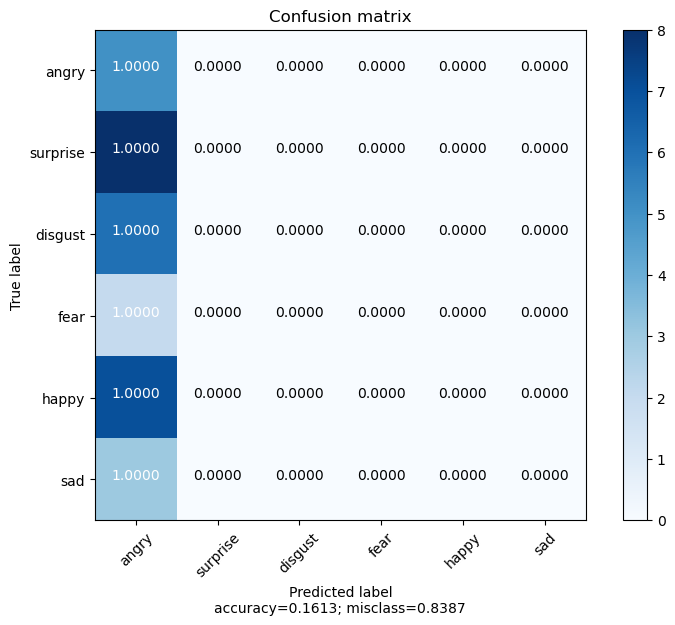

In [78]:
classes = ["angry", "surprise" , "disgust", "fear", "happy", "sad"]
plot_confusion_matrix(result2,classes)